This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    

Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


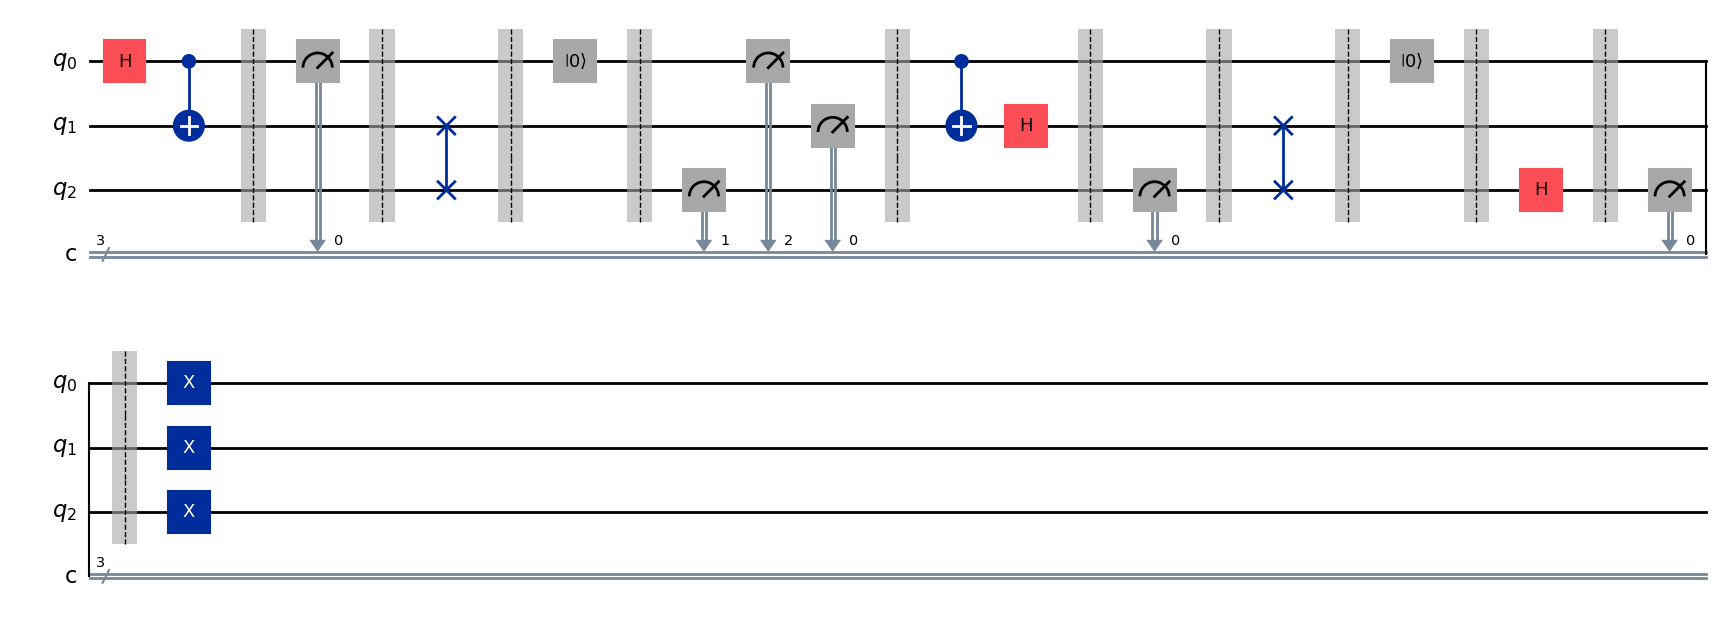

In [2]:
N_q = 3
N_m = 3
qc_small = QuantumCircuit(N_q, N_m)
qc_small.h(0)
qc_small.cx(0,1)
qc_small.barrier()
qc_small.measure(0,0)
qc_small.barrier()
qc_small.swap(1,2)
qc_small.barrier()  
qc_small.reset(0)
qc_small.barrier()
qc_small.measure(2,1)
qc_small.measure(0,2)
qc_small.measure(1,0)
qc_small.barrier()
qc_small.cx(0,1)
qc_small.h(1)
qc_small.barrier()
qc_small.measure(2,0)
qc_small.barrier()
qc_small.swap(1,2)
qc_small.barrier()

qc_small.reset(0)
qc_small.barrier()

qc_small.h(2)
qc_small.barrier()
qc_small.measure(2,0)

qc_small.barrier()



qc_small.x(range(3))
qc_small.draw("mpl")



In [3]:
# 1) Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

# 2) Use only N qubits
qubits_layout = list(range(N_q))

# 3) Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
device_param.save_to_json("./")  # writes ./device_parameters.json
print("Wrote ./device_parameters.json")

Device parameters are valid. We can save them. 
Device parameters saved successfully.
Wrote ./device_parameters.json


In [4]:

from quantum_gates.gates import NoiseFreeGates  # 

sim = MrAndersonSimulator(
    gates=NoiseFreeGates,        # <- ideal gates (no noise)
    CircuitClass=EfficientCircuit # or EfficientCircuit
)

bit_flip_bool = False
#cycles = 2
initial_psi = np.zeros(2**N_q)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(N_q))  # logical qubit 0→physical 0, 1→1, etc.
shots = 100

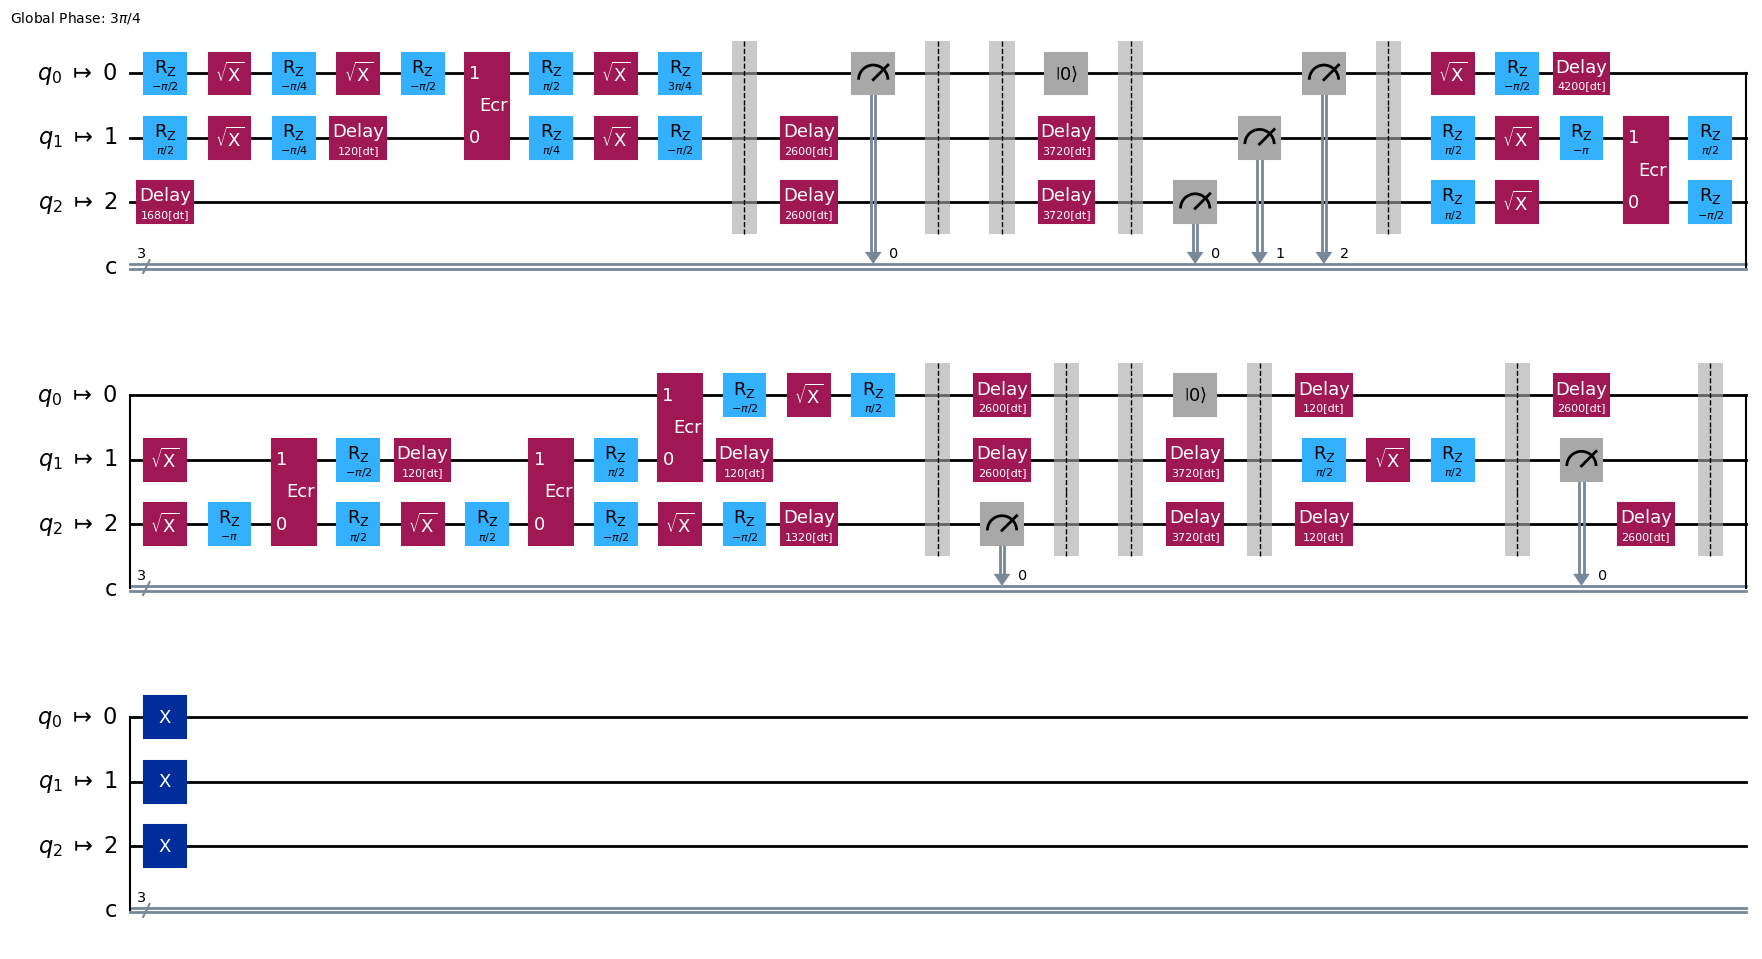

In [5]:



needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc_small.data)

t_circ = transpile(
    qc_small,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=100,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

t_circ.draw("mpl")

In [6]:

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=N_q,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

---- Preprocessed data ----
Chunk 0: rz[0] , sx[0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , rz[1] , sx[1] , rz[1] , delay[2] , delay[1] , delay[2]
Fancy 1: mid_measurement qubits=[0] clbits=[0]
Fancy 2: reset_qubits qubits=[0]
Chunk 3: delay[1] , delay[2]
Fancy 4: mid_measurement qubits=[2] clbits=[0]
Fancy 5: mid_measurement qubits=[1] clbits=[1]
Fancy 6: mid_measurement qubits=[0] clbits=[2]
Chunk 7: sx[0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , ecr[2, 1] , rz[1] , sx[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , delay[1] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , delay[1] , rz[2] , sx[2] , rz[2] , delay[2] , delay[0] , delay[1]
Fancy 8: mid_measurement qubits=[2] clbits=[0]
Fancy 9: reset_qubits qubits=[0]
Chunk 10: delay[1] , delay[2] , delay[0] , rz[1] , sx[1] , rz[1] , delay[2] , delay[0]
Fancy 11: mid_measurement qubits=[1] clbits=[0]
Chunk 12: delay[2] , x[0] ,

Post processing and plotting hists

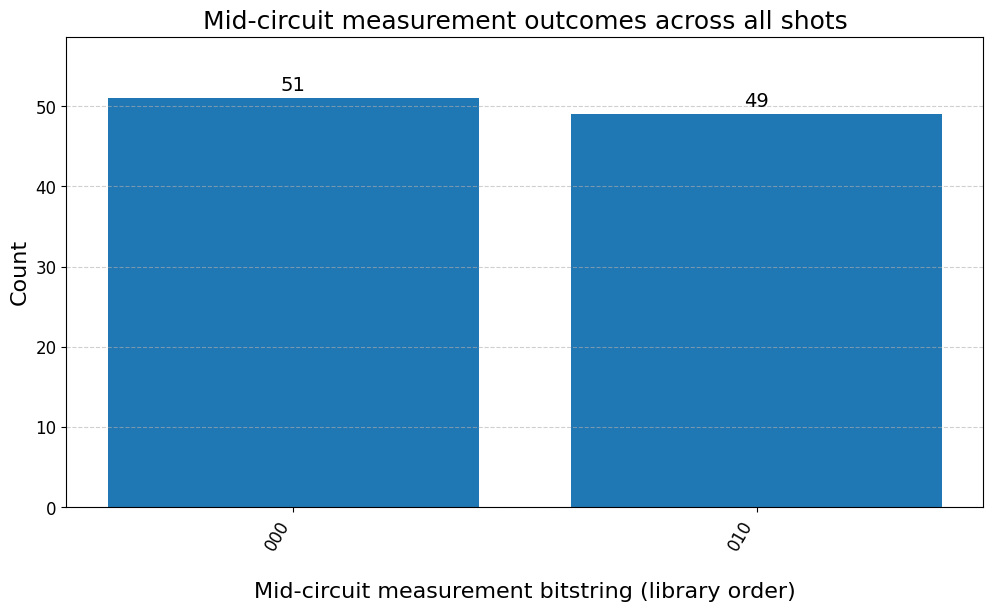

Mid-circuit measurement counts: {'000': 51, '010': 49}


In [7]:

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=14, color="black")

plt.xlabel("\nMid-circuit measurement bitstring (library order)", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Mid-circuit measurement outcomes across all shots",fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=12)   # tilt x-axis labels

plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

Modified Hist Plot of above 5% counts 

Filtered mid-circuit measurement counts

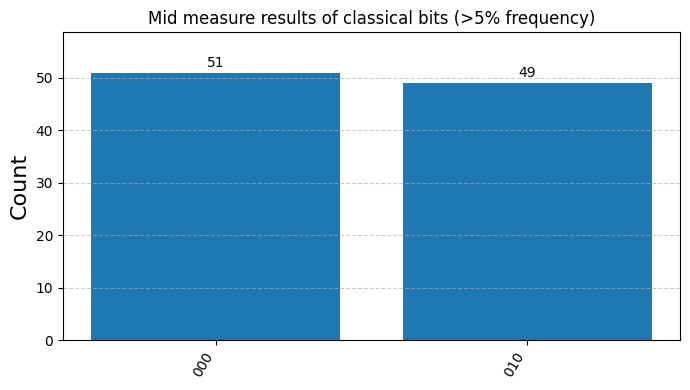

In [8]:
threshold = 0.05 * shots  # 5% cutoff

# --- Filter ---
filtered_counts = {k: v for k, v in mid_counts.items() if v >= threshold}

# --- Sort by bitstring (optional) ---
filtered_labels = list(sorted(filtered_counts.keys()))
filtered_values = [filtered_counts[k] for k in filtered_labels]

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(filtered_labels, filtered_values, color="#1f77b4")  # same default Aer blue

# Extend y-axis a bit to fit annotations
max_val = max(filtered_values)
plt.ylim(0, max_val * 1.15)

# Annotate bar tops
for bar, val in zip(bars, filtered_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, str(val),
             ha='center', va='bottom', fontsize=10, color="black")

# Match Aer-style axes
plt.ylabel("Count", fontsize=16)
plt.xlabel("")  # Aer histograms usually skip x-axis label
plt.title("Mid measure results of classical bits (>5% frequency)", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout to match Aer formatting
plt.tight_layout()
plt.show()

Probabilities Generated by Final Measures

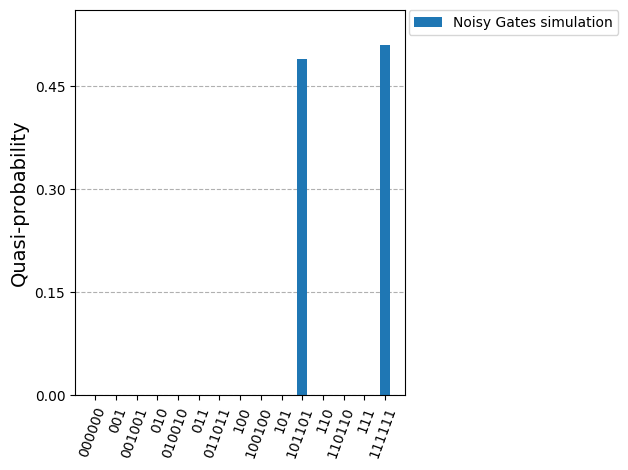

In [9]:
# Probabilities Generated by Final Measures
measured_qubit = N_m
counts_ng = fix_counts(probs, measured_qubit)
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])

In [10]:
counts_ng

{'000000': 6.888418179925451e-66,
 '001': 0,
 '010': 0,
 '011': 0,
 '100': 0,
 '101': 0,
 '110': 0,
 '111': 0,
 '001001': 1.837205733760774e-33,
 '010010': 7.169578105636694e-66,
 '011011': 1.9121937228938667e-33,
 '100100': 1.837205733760774e-33,
 '101101': 0.49,
 '110110': 1.9121937228938667e-33,
 '111111': 0.51}

Comparison with AER

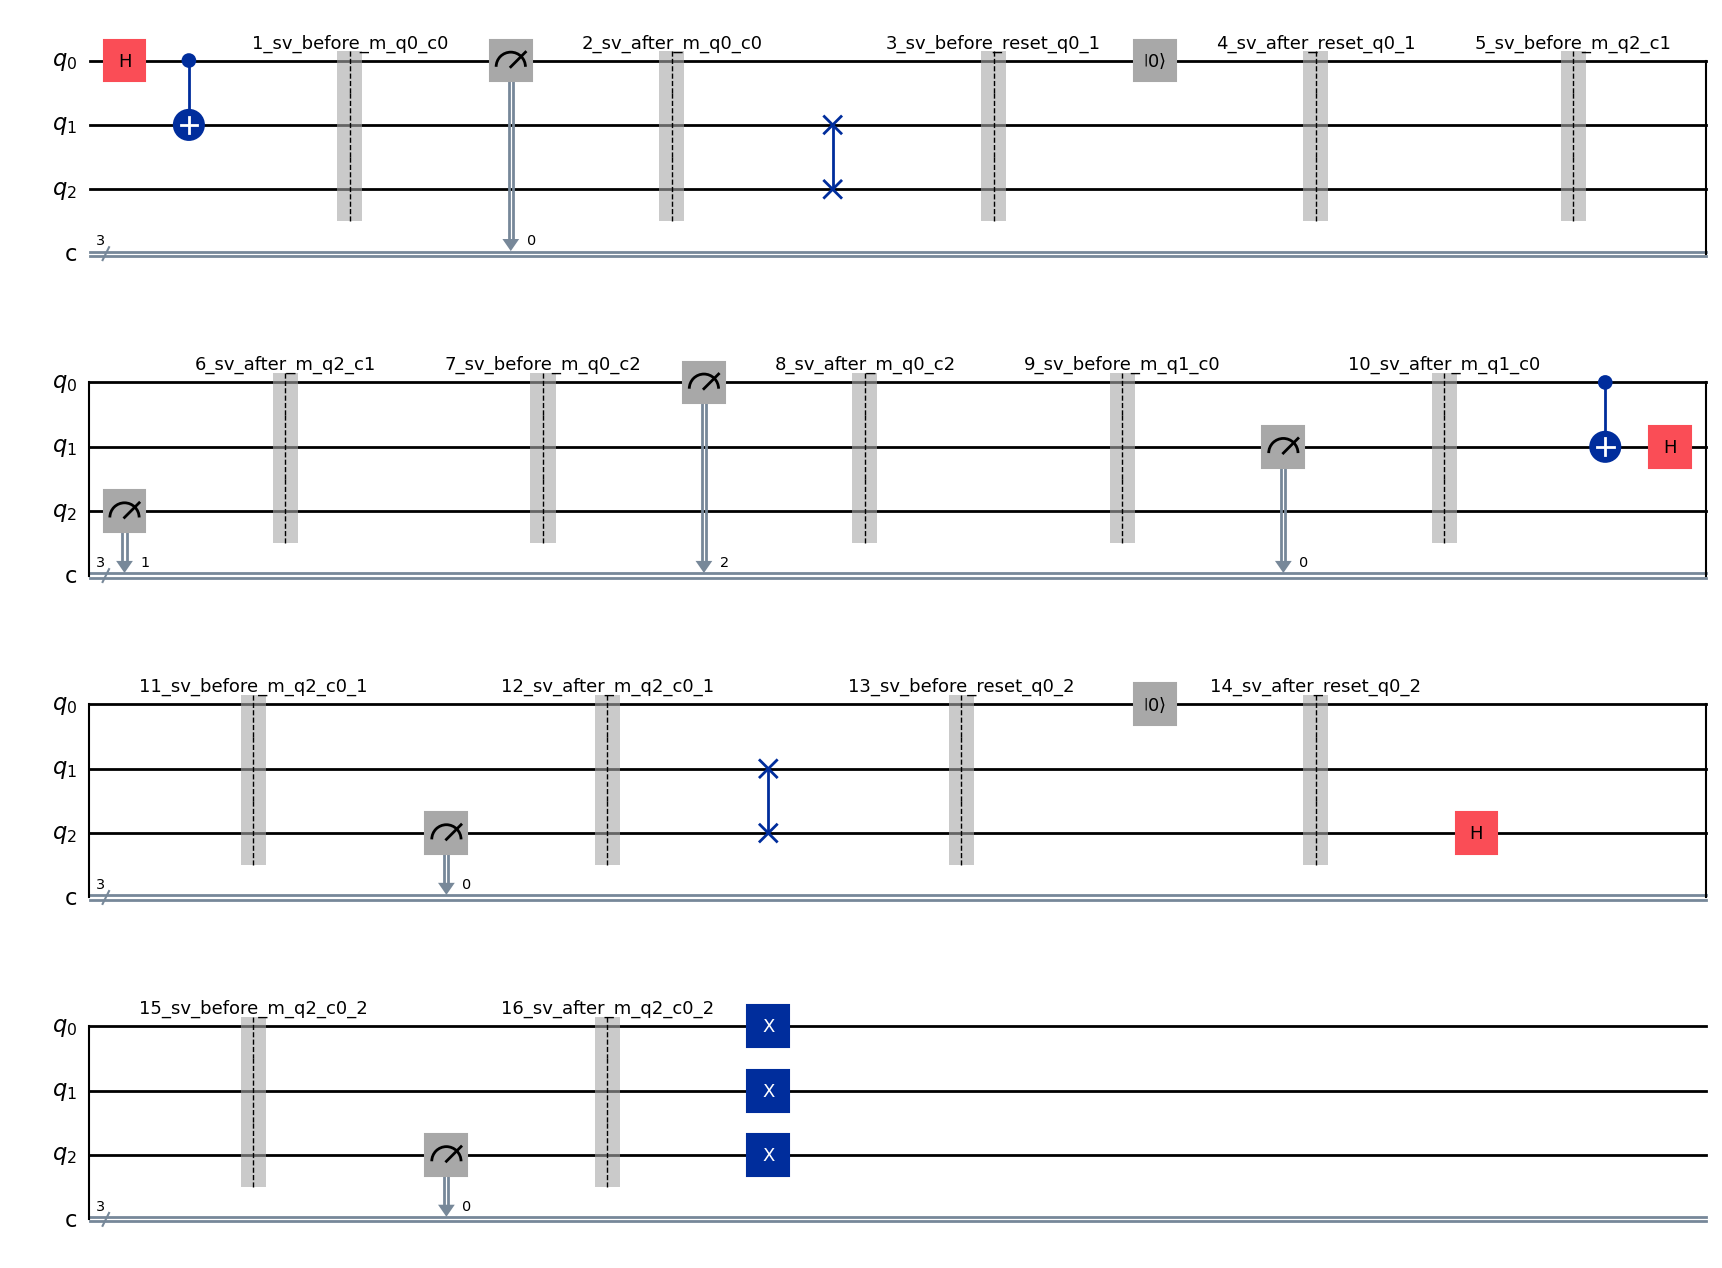

In [11]:
# comparison circuit with readouts to save statevectors before and after mid-circuit measurements and resets

N_q = 3
aer_qc_small = QuantumCircuit(3, 3)

aer_qc_small.h(0)
aer_qc_small.cx(0,1)

# --- measure(0,0)
aer_qc_small.save_statevector(label="1_sv_before_m_q0_c0")
aer_qc_small.measure(0,0)
aer_qc_small.save_statevector(label="2_sv_after_m_q0_c0")

aer_qc_small.swap(1,2)

# --- reset(0)
aer_qc_small.save_statevector(label="3_sv_before_reset_q0_1")
aer_qc_small.reset(0)
aer_qc_small.save_statevector(label="4_sv_after_reset_q0_1")

# --- measure(2,1)
aer_qc_small.save_statevector(label="5_sv_before_m_q2_c1")
aer_qc_small.measure(2,1)
aer_qc_small.save_statevector(label="6_sv_after_m_q2_c1")

# --- measure(0,2)
aer_qc_small.save_statevector(label="7_sv_before_m_q0_c2")
aer_qc_small.measure(0,2)
aer_qc_small.save_statevector(label="8_sv_after_m_q0_c2")

# --- measure(1,0)
aer_qc_small.save_statevector(label="9_sv_before_m_q1_c0")
aer_qc_small.measure(1,0)
aer_qc_small.save_statevector(label="10_sv_after_m_q1_c0")

aer_qc_small.cx(0,1)
aer_qc_small.h(1)

# --- measure(2,0) (first time)
aer_qc_small.save_statevector(label="11_sv_before_m_q2_c0_1")
aer_qc_small.measure(2,0)
aer_qc_small.save_statevector(label="12_sv_after_m_q2_c0_1")

aer_qc_small.swap(1,2)

# --- reset(0) (second time)
aer_qc_small.save_statevector(label="13_sv_before_reset_q0_2")
aer_qc_small.reset(0)
aer_qc_small.save_statevector(label="14_sv_after_reset_q0_2")

aer_qc_small.h(2)

# --- measure(2,0) (second time)
aer_qc_small.save_statevector(label="15_sv_before_m_q2_c0_2")
aer_qc_small.measure(2,0)
aer_qc_small.save_statevector(label="16_sv_after_m_q2_c0_2")


aer_qc_small.x(range(3))

# Optional: draw
aer_qc_small.draw("mpl")




In [12]:
# --- Run and collect statevectors ---
# Run on Aer *statevector* simulator so mid-circuit saves + collapse work
sim = AerSimulator(method="statevector")
result = sim.run(transpile(aer_qc_small, sim), shots=shots, seed_simulator=123).result()

data = result.data(0)  # dict of all saved objects keyed by label
counts = result.get_counts()
# Print all entries whose key starts with 'sv_' (the labels we used)

# Function to convert Qiskit statevector to standard ordering |q0 q1 q2>
def qiskit_to_standard_ordering(statevector, num_qubits=3):
    """
    Convert Qiskit's statevector ordering (q2 q1 q0) to standard ordering (q0 q1 q2)
    """
    # Create a new array for the reordered statevector
    new_statevector = np.zeros_like(statevector)
    
    # Iterate through all basis states
    for i in range(len(statevector)):
        # Get the binary representation with num_qubits digits
        binary_old = format(i, f'0{num_qubits}b')
        
        # Reverse the qubit order (q2 q1 q0 -> q0 q1 q2)
        binary_new = binary_old[::-1]
        
        # Convert back to integer index
        new_index = int(binary_new, 2)
        
        # Place the amplitude in the new position
        new_statevector[new_index] = statevector[i]
    
    return new_statevector

# Print all entries whose key contains 'sv_' (the labels we used)
for label, vec in data.items():
    if 'sv_' in label:
        print(f"\n[{label}]")
        print("Raw Qiskit ordering (|q₂ q₁ q₀⟩):")
        print(np.array(vec))
        
        # Convert to standard ordering
        std_vec = qiskit_to_standard_ordering(vec)
        print("Standard ordering (|q₀ q₁ q₂⟩):")
        print(std_vec)
        
        # Optional: Print in a more readable format
        print("Standard ordering with basis states:")
        for i, amp in enumerate(std_vec):
            if abs(amp) > 1e-10:  # Only print non-zero amplitudes
                basis = format(i, f'0{3}b')
                print(f"  |{basis}⟩: {amp:.6f}")



[1_sv_before_m_q0_c0]
Raw Qiskit ordering (|q₂ q₁ q₀⟩):
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
Standard ordering (|q₀ q₁ q₂⟩):
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]
Standard ordering with basis states:
  |000⟩: 0.707107+0.000000j
  |110⟩: 0.707107+0.000000j

[2_sv_after_m_q0_c0]
Raw Qiskit ordering (|q₂ q₁ q₀⟩):
[0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Standard ordering (|q₀ q₁ q₂⟩):
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
Standard ordering with basis states:
  |110⟩: 1.000000+0.000000j

[13_sv_before_reset_q0_2]
Raw Qiskit ordering (|q₂ q₁ q₀⟩):
[0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.70710678+0.j 0.        +0.j]
Standard ordering (|q₀ q₁ q₂⟩):
[0.        +0.j 0.        +0.j 0.70710678+0.j 0.70710678+0.j
 0.        +0.j 0.        

C:\Users\npace\AppData\Local\Temp\ipykernel_57556\4271187390.py:19: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for i in range(len(statevector)):


Aer All clbits counts: {'000': 50, '010': 50}


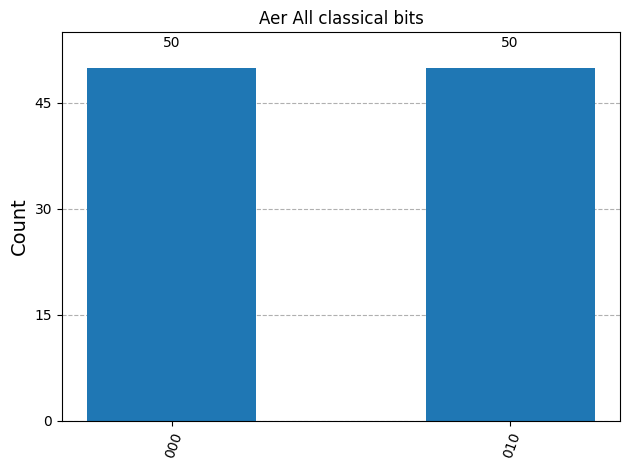

In [13]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")

Filtering Example

Truncated to final 2 bits: {'000': 50, '010': 50}


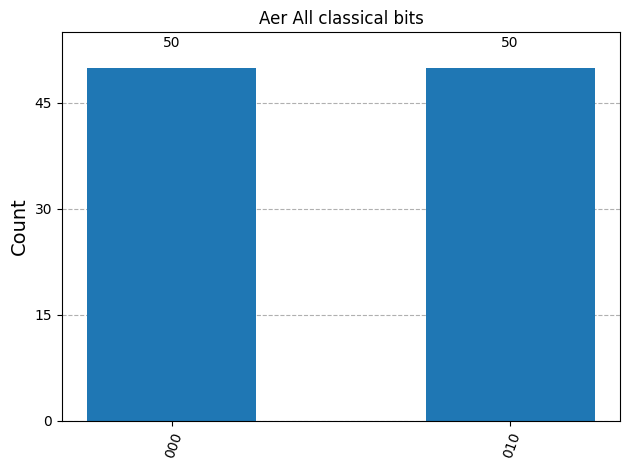

In [14]:
# Keep only the final measurement bits
final_counts = marginal_counts(counts, indices=range(N_q))

print("Truncated to final 2 bits:", final_counts)
plot_histogram(final_counts, title='Aer All classical bits')